# Customer Segmentation via Clustering
Using data from "Online Shoppers Purchasing Intention Dataset" https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

## Load Data

In [32]:
# import libraries
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import umap
from sklearn import preprocessing

In [ ]:
# load and briefly look over data
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# data from "Online Shoppers Purchasing Intention Dataset" https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset
df_shoppers = pd.read_csv('online_shoppers_intention.csv') 
print(df_shoppers.describe())
print(df_shoppers.info())

       Administrative  Administrative_Duration  Informational  Informational_Duration  ProductRelated  ProductRelated_Duration   BounceRates     ExitRates    PageValues    SpecialDay  OperatingSystems       Browser        Region   TrafficType
count    12330.000000             12330.000000   12330.000000            12330.000000    12330.000000             12330.000000  12330.000000  12330.000000  12330.000000  12330.000000      12330.000000  12330.000000  12330.000000  12330.000000
mean         2.315166                80.818611       0.503569               34.472398       31.731468              1194.746220      0.022191      0.043073      5.889258      0.061427          2.124006      2.357097      3.147364      4.069586
std          3.321784               176.779107       1.270156              140.749294       44.475503              1913.669288      0.048488      0.048597     18.568437      0.198917          0.911325      1.717277      2.401591      4.025169
min          0.000000       

## Preprocessing

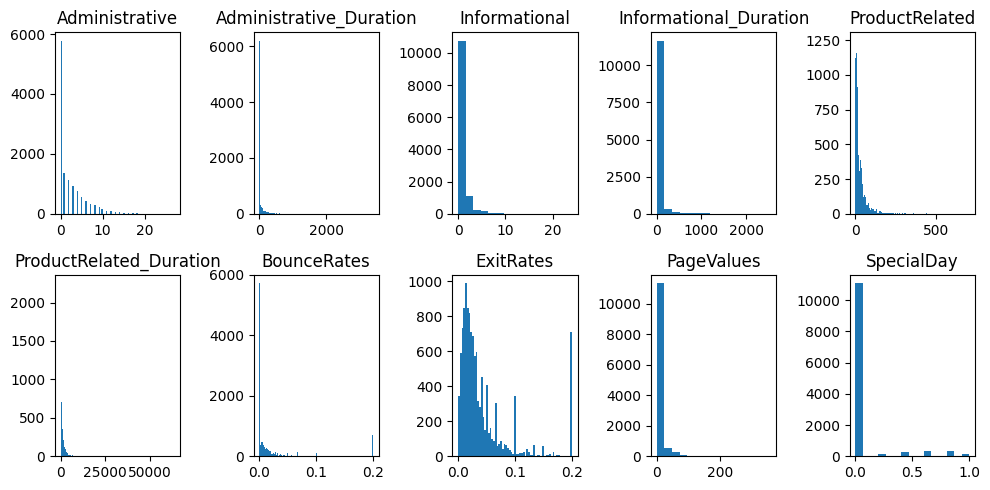

In [5]:
# separate numerical and categorical data
df_shoppers_num = df_shoppers.loc[:, :'SpecialDay']
df_shoppers_cat = df_shoppers.loc[:, 'OperatingSystems':]

# visualize the spread of numerical & ordinal data – to decide standardization algorithm
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
idx = 0
for row in ax:
    for axis in row:
        # how to check for outliers: x=feature, y=count; log-norm -> find hidden cluster in range
        x = df_shoppers.iloc[:,idx]
        #y = df_shoppers.iloc[:,idx].value_counts()
        axis.hist(x, bins='auto')
        axis.set(title=df_shoppers_num.columns[idx])
        idx += 1
fig.tight_layout()

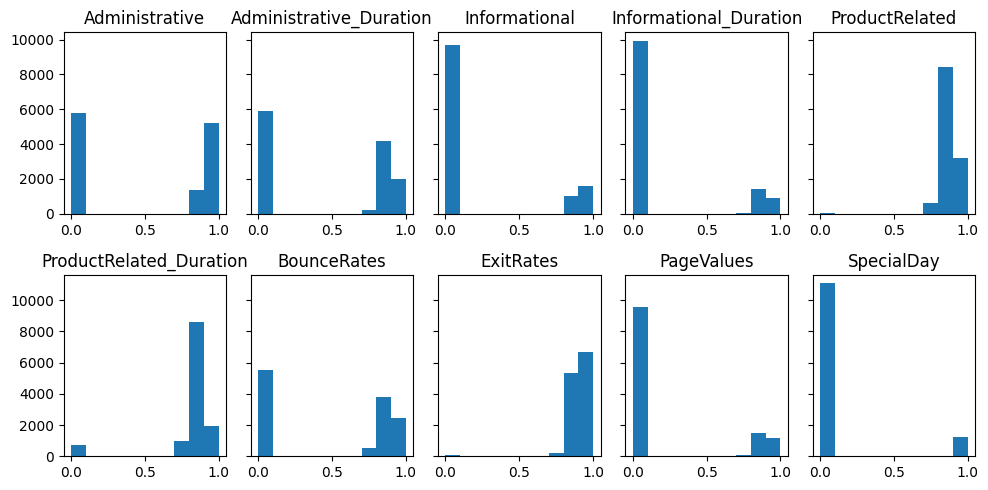

In [6]:
# standardize the numerical data, data is heavily skewed and nonneg -> use log-normalization
df_norm = df_shoppers_num.copy()
for col in range(df_norm.shape[1]):
    log_column = np.log(df_norm.iloc[:,col].copy() + 1e-10)
    log_min = np.min(log_column)
    log_max = np.max(log_column)
    df_norm.iloc[:,col] = (log_column - log_min) / (log_max - log_min)


# visualize normalized numerical data
fig, ax = plt.subplots(2, 5, sharey='row', figsize=(10, 5))
idx = 0
for row in ax:
    for axis in row:
        x = df_norm.iloc[:,idx]
        axis.hist(x)
        axis.set(title=df_norm.columns[idx])
        idx += 1
fig.tight_layout()

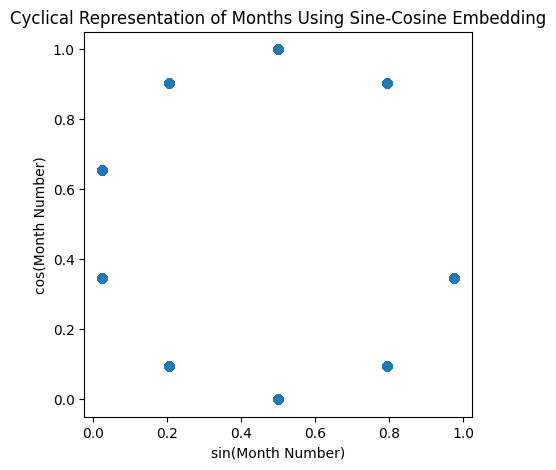

In [7]:
# sine-cosine embedding for months (months have a cyclical relationship such that adjacent months like Jan/Dec (endpoints) & Jun/July are closer together)
le = preprocessing.LabelEncoder() # first label-embed the months
month_order = {'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3, 'May': 4, 'June': 5, 'Jul': 6, 'Aug': 7, 'Sep': 8, 'Oct': 9, 'Nov': 10, 'Dec': 11}
df_months = df_shoppers['Month'].map(month_order)
df_months = (df_months - np.min(df_months)) / (np.max(df_months) - np.min(df_months)) # min-max normalize

# project 1D input x -> 2D circle such that dimen1=sin(2pi*x), dimen2=cos(2pi*x)
monthX = (np.sin(2 * np.pi * df_months) + 1) / 2
monthY = (np.cos(2 * np.pi * df_months) + 1) / 2
df_months = pd.concat([monthX, monthY], axis=1)
df_months.columns = ['MonthX', 'MonthY']

# visualize 2D plot
plt.figure(figsize=(5,5));
plt.scatter(monthX, monthY);
plt.title('Cyclical Representation of Months Using Sine-Cosine Embedding');
plt.xlabel('sin(Month Number)');
plt.ylabel('cos(Month Number)');


og: (12330, 67)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


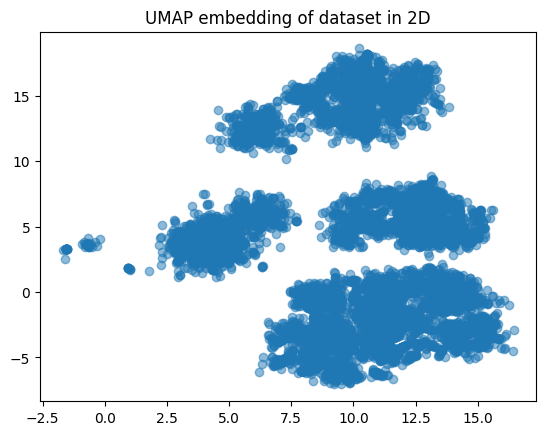

In [8]:
# one-hot encode remaining categorical variables
df_enc = pd.get_dummies(df_shoppers_cat, columns=df_shoppers_cat.columns[:-2])

# combine numerical, sine-cosine embedded, and one-hot encoded features
df_shoppers_cleaned = pd.concat([df_norm, df_months, df_enc], axis=1)
print(f'og: {df_shoppers_cleaned.shape}')

# preserve density in data transformation for clustering
df_umap = umap.UMAP(random_state=42, 
                    n_neighbors=30,
                    min_dist=0.0,
                    n_components=15, 
                    densmap=True).fit_transform(df_shoppers_cleaned) # data for algorithm use

# get representation of data in 2D for visualization
df_umap_2D = umap.UMAP(random_state=42, 
                        n_neighbors=30,
                        min_dist=0.0,
                        n_components=2, 
                        densmap=True).fit_transform(df_shoppers_cleaned) # data for plotting ONLY

plt.scatter(df_umap_2D[:,0], df_umap_2D[:,1], alpha=.5)
plt.title('UMAP embedding of dataset in 2D');


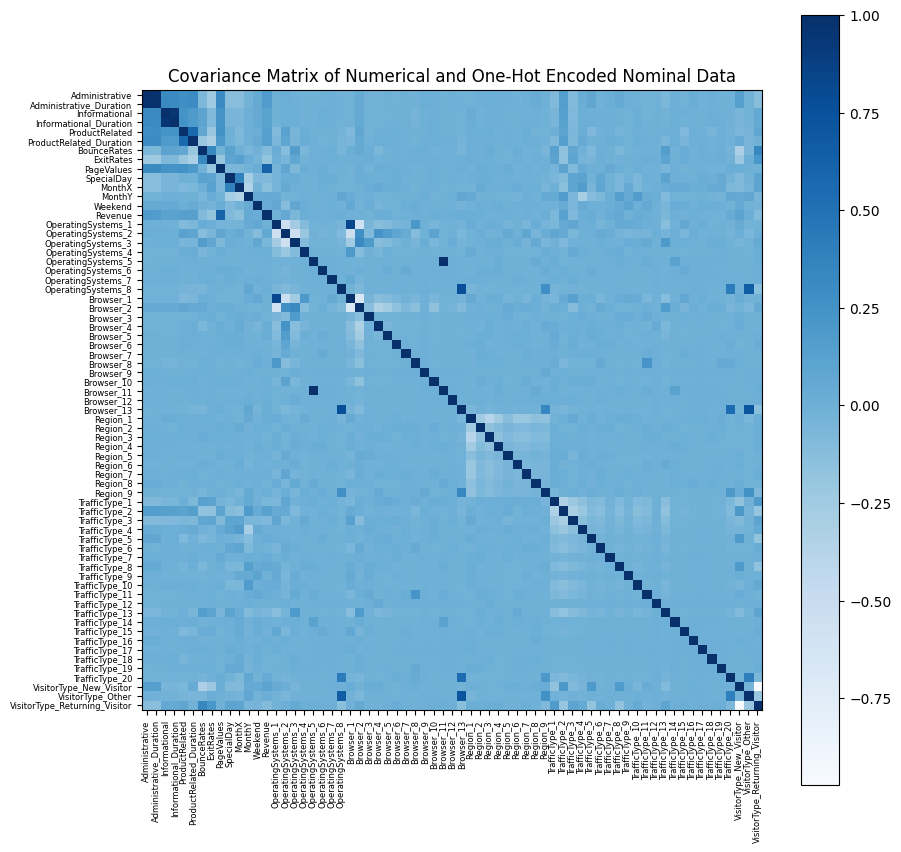

In [9]:
# use correlation matrix as an intermediary step to finding relevent feature combinations
corr_matr = df_shoppers_cleaned.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(10,10))
plt.imshow(corr_matr, cmap='Blues')
plt.xticks(ticks=range(df_shoppers_cleaned.shape[1]), labels=df_shoppers_cleaned.columns, fontsize=6, rotation='vertical');
plt.yticks(ticks=range(df_shoppers_cleaned.shape[1]), labels=df_shoppers_cleaned.columns, fontsize=6);
plt.colorbar();
plt.title('Covariance Matrix of Numerical and One-Hot Encoded Nominal Data');

## Apply Clustering Algorithms

In [ ]:
# import clustering algorithms
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

In [11]:
# visualize_clusters function, so that we can easily do the umap
def visualize_clusters(umap_data, cluster_labels, title, axes):
    """
    Visualize clustering output.
    - umap_data = use df_umap2D
    - cluster_labels = the label output of clustering algorithm
    - title = name of clustering algorithm to use put in title
    - axes = ['x-axis', 'y-axis']
    """
    df_clustered = pd.concat([pd.DataFrame(umap_data), pd.DataFrame(cluster_labels, columns=['cluster_label'])], axis=1)
    fig = plt.figure(figsize=(7, 7))
    for cluster in np.unique(cluster_labels):
        data = df_clustered.query(f'cluster_label == {cluster}')
        plt.scatter(data.iloc[:,0], data.iloc[:,1], label=f'Cluster {cluster}', alpha=0.2)
    fig.legend()
    plt.title(f'{title} Clustering Visualized on a 2D Map')
    plt.xlabel(axes[0])
    plt.ylabel(axes[1])
    fig.tight_layout()

In [12]:
def DBSCAN_visualize_eps(data, min_samples, eps, metric):
    """
    Given min_samples(= 2 * data.shape[1]), compute the optimal epsilon via the elbow of the k-nearest neighbors plot
    """
    neighbors = NearestNeighbors(n_neighbors=min_samples - 1, metric=metric).fit(data)
    distances, indices = neighbors.kneighbors(data)
    distances = np.sort(distances[:, -1])[::-1]
    plt.plot(distances)
    plt.title("K-Nearest Neighbours")
    plt.xlim(0, 500) # crook (point of max curvature) of k-distance elbow plot located at ~ y = 4.1
    plt.hlines(y=eps, xmin=0, xmax=2000, colors='g') 
    return eps

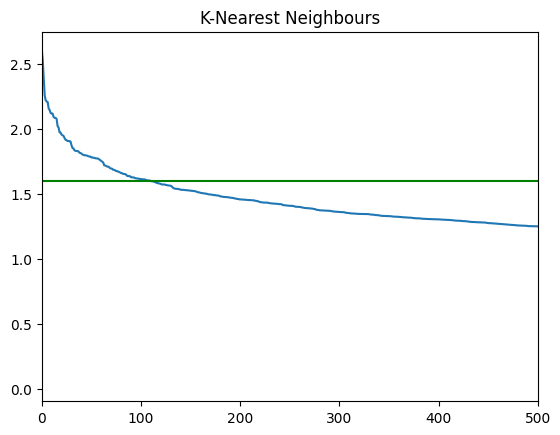

In [ ]:
# determine DBSCAN parameters
min_samples = df_umap.shape[1] * 2 # for datasets with dimen > 2, opt for 2 * num_dimen (Sander et al., 1998)
eps = DBSCAN_visualize_eps(df_umap, min_samples, 1.6, 'euclidean')

# perform DBSCAN with the previously determined parameters
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_umap)


DBSCAN Per Cluster Point Count:
Cluster 0 has 2597 points
Cluster 1 has 6097 points
Cluster 2 has 2318 points
Cluster 3 has 1245 points
Cluster -1 has 14 points
Cluster 4 has 59 points


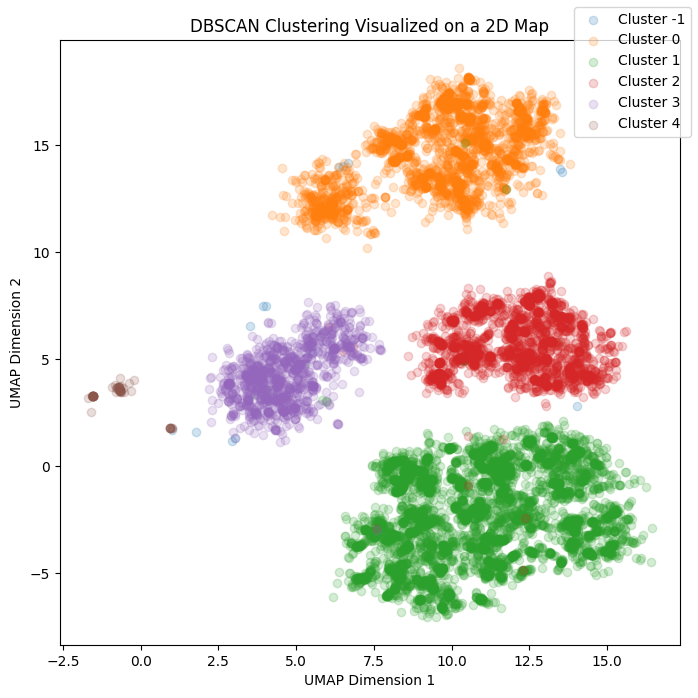

In [14]:
# visualize DBSCAN
visualize_clusters(df_umap_2D, clustering.labels_, 'DBSCAN', ['UMAP Dimension 1', 'UMAP Dimension 2'])

# number of points per cluster
dbscan_labels = clustering.labels_ 
dbscan_cluster_points = {}
seen_dbscan = set()

for cluster_id in dbscan_labels:
    if cluster_id not in seen_dbscan:
        seen_dbscan.add(cluster_id)
        indices = np.where(dbscan_labels == cluster_id)[0]
        dbscan_cluster_points[cluster_id] = df_umap[indices]

print("DBSCAN Per Cluster Point Count:")
for cluster_id, points in dbscan_cluster_points.items():
    print(f"Cluster {cluster_id} has {len(points)} points")


DBSCAN Per Cluster Point Count:
Cluster 0 has 5379 points
Cluster 1 has 4221 points
Cluster 2 has 2206 points
Cluster 3 has 524 points


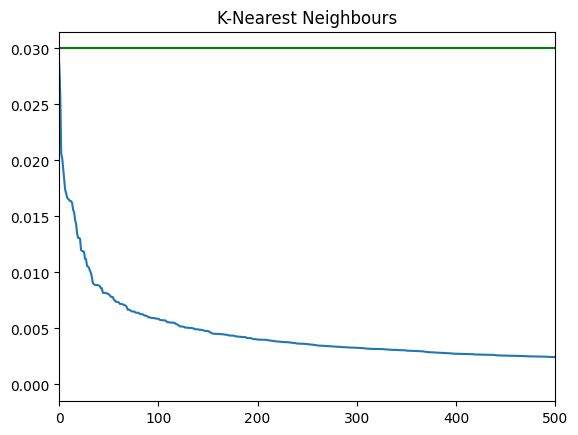

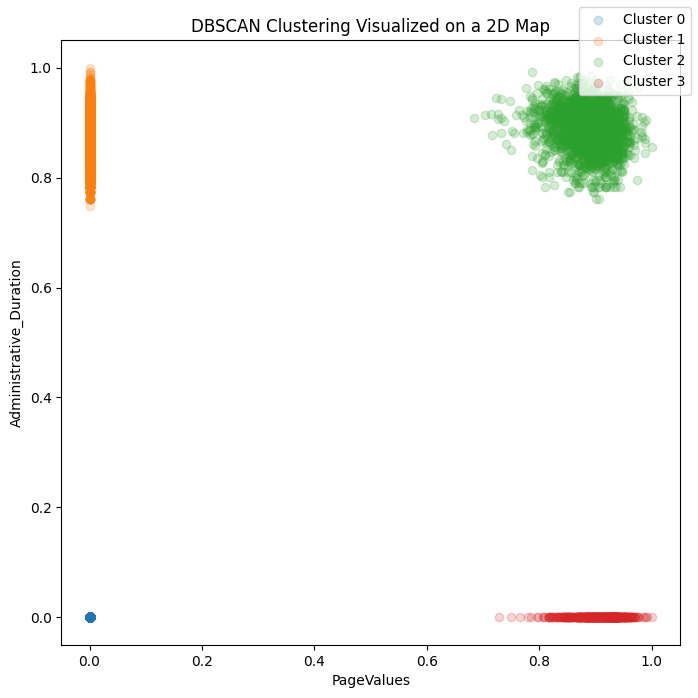

In [ ]:
# apply DBSCAN for specific feature combinations
pagev_addur = ['PageValues', 'Administrative_Duration']
df_features = df_shoppers_cleaned.loc[:,pagev_addur]

min_samples = 3 # default, best to use min_samples ≥ 3
eps = DBSCAN_visualize_eps(df_features, min_samples, 0.03, 'euclidean'); # eps=.02 is closer to the plot's elbow, but clusters more accurate for eps=.03
features_clustering = DBSCAN(min_samples=min_samples, eps=eps).fit(df_features)

# plot dbscan results
visualize_clusters(df_features, features_clustering.labels_, 'DBSCAN', pagev_addur)

# number of points per cluster
dbscan_feature_labels = features_clustering.labels_ 
dbscan_feature_cluster_points = {}
seen_dbscan = set()

for cluster_id in dbscan_feature_labels:
    if cluster_id not in seen_dbscan:
        seen_dbscan.add(cluster_id)
        indices = np.where(dbscan_feature_labels == cluster_id)[0]
        dbscan_feature_cluster_points[cluster_id] = df_features.iloc[indices].values

print("DBSCAN Per Cluster Point Count:")
for cluster_id, points in dbscan_feature_cluster_points.items():
    print(f"Cluster {cluster_id} has {len(points)} points")


BIRCH Per Cluster Point Count:
Cluster 5 has 2173 points
Cluster 2 has 2897 points
Cluster 3 has 2318 points
Cluster 1 has 3201 points
Cluster 0 has 1312 points
Cluster 4 has 429 points


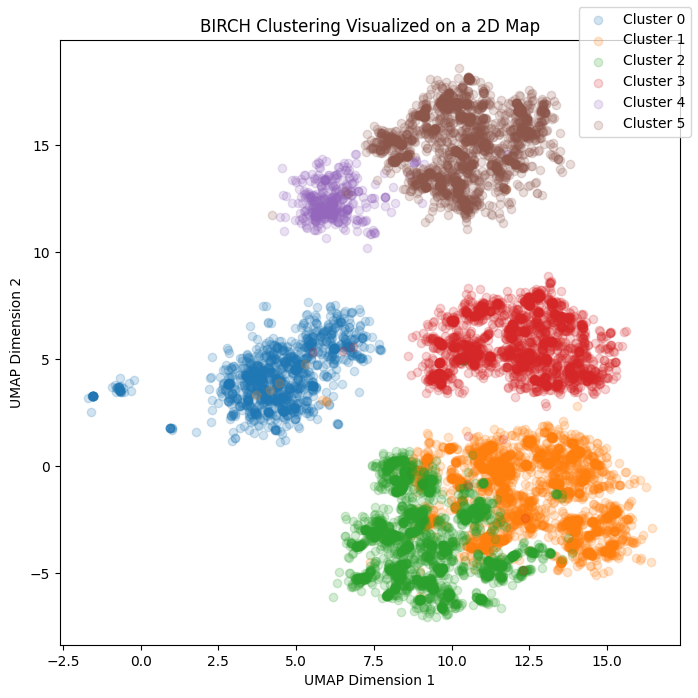

In [ ]:
# apply Sklearn's Birch clustering

# prepare function to accomodate birch
birch_model = Birch(n_clusters=6)
birch_model.fit(df_umap)
birch_cluster_labels = birch_model.labels_

# using premade function visualize_clusters
visualize_clusters(df_umap_2D, birch_cluster_labels, 'BIRCH', ['UMAP Dimension 1', 'UMAP Dimension 2'])

# number of points per cluster
birch_labels = birch_model.labels_
birch_cluster_points = {}
seen_birch = set()

for cluster_id in birch_labels:
    if cluster_id not in seen_birch:
        seen_birch.add(cluster_id)
        indices = np.where(birch_labels == cluster_id)[0]
        birch_cluster_points[cluster_id] = df_umap[indices]

print("BIRCH Per Cluster Point Count:")
for cluster_id, points in birch_cluster_points.items():
    print(f"Cluster {cluster_id} has {len(points)} points")


BIRCH Per Cluster Point Count:
Cluster 3 has 5379 points
Cluster 1 has 4221 points
Cluster 2 has 2206 points
Cluster 0 has 524 points


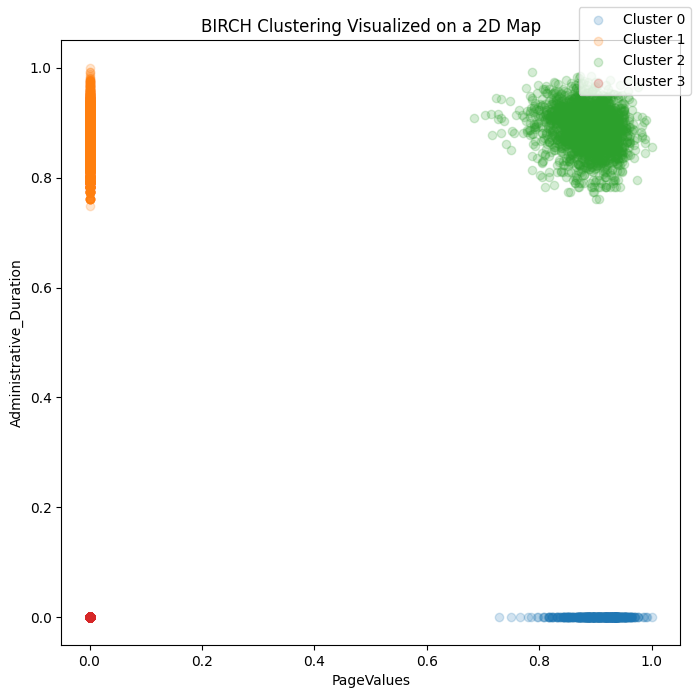

In [17]:
# selecting "ExitRates" and "ProductRelated_Duration" as our features bc of correlation matrix
birch_features = df_shoppers_cleaned[pagev_addur].values  

# using BIRCH 
birch = Birch(threshold=0.1, n_clusters=4)  
birch.fit(birch_features)
birch_feature_labels = birch.labels_

df_shoppers_cleaned_birch = df_shoppers_cleaned.copy()
df_shoppers_cleaned_birch['Cluster'] = birch_feature_labels

# visualizing
visualize_clusters(birch_features, birch_feature_labels, 'BIRCH', pagev_addur)

# number of points per cluster
birch_feature_labels = birch.labels_
birch_feature_cluster_points = {}
seen_birch = set()

for cluster_id in birch_feature_labels:
    if cluster_id not in seen_birch:
        seen_birch.add(cluster_id)
        indices = np.where(birch_feature_labels == cluster_id)[0]
        birch_feature_cluster_points[cluster_id] = birch_features[indices]

print("BIRCH Per Cluster Point Count:")
for cluster_id, points in birch_feature_cluster_points.items():
    print(f"Cluster {cluster_id} has {len(points)} points")


## Evaluate clustering methods 

In [18]:
# Calculate silhouette score for dbscan
sk_db_score = silhouette_score(df_umap, dbscan_labels)
print("Sklearn Silhouette Score for DBSCAN:", sk_db_score)

Sklearn Silhouette Score for DBSCAN: 0.62003654


In [19]:
# calculate silhouette score for birch
sk_birch_score = silhouette_score(df_umap, birch_labels)
print("Sklearn Silhouette Score for BIRCH:", sk_birch_score)

Sklearn Silhouette Score for BIRCH: 0.37797463


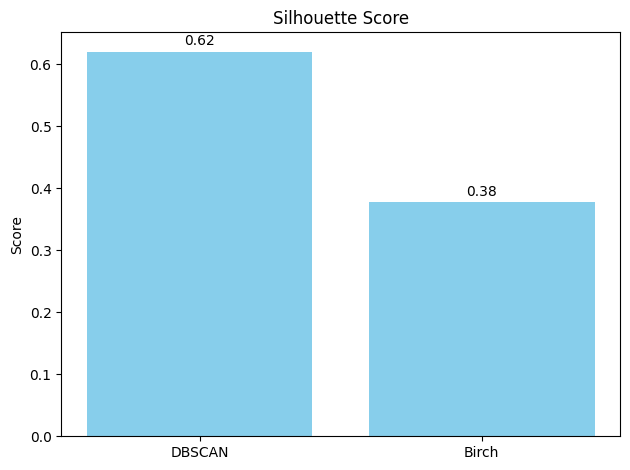

In [ ]:
# visualizing the difference in silhouette scores

silhouette_scores = {
    'DBSCAN': sk_db_score,
    'Birch': sk_birch_score,
}

plt.bar(silhouette_scores.keys(), silhouette_scores.values(), color='skyblue')
plt.title('Silhouette Score')
plt.ylabel('Score')
for i, v in enumerate(silhouette_scores.values()):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()


## Customer Segmentation Results

Four Main Customer Types
1. Traffic: Spends significant time on non-revenue generating pages
2. Lost: Spends little time on non-revenue generating pages (Accidentally stumbled on website)
3. Informed Buyer: Spends significant time on revenue generating pages
4. Casual Buyer: Spends little time on revenue generating pages

Solutions: Make high page-value links more prominent on website to encourage greater revenue-generating page browsing


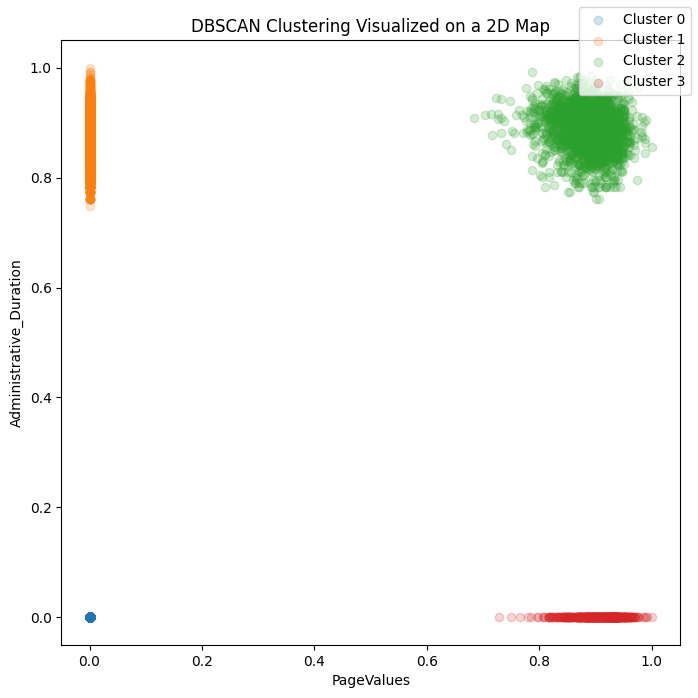

In [ ]:
# customer segmentation
visualize_clusters(df_features, features_clustering.labels_, 'DBSCAN', pagev_addur)

# Results:
print('Four Main Customer Types')
print('1. Traffic: Spends significant time on non-revenue generating pages')
print('2. Lost: Spends little time on non-revenue generating pages (Accidentally stumbled on website)')
print('3. Informed Buyer: Spends significant time on revenue generating pages')
print('4. Casual Buyer: Spends little time on revenue generating pages')
print('\nSolution: Make high page-value links more prominent on website to encourage greater revenue-generating page browsing.')